# In this file, Our team's works includes:


*   Creating a process for labeling the data (not included in this source code but in the report)
*   Perform data cleaning on a dataset from Kaggle
*   Training a model to classify comments' sentiments
*   Visualize the results



# 1. Read and transform data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score

In [ ]:
sheet_id = '1iVjq9zLHWVEZm54cLnHEGw-w7NHjZkCLE1xy7tYoshU'

data = pd.read_csv(f'https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=csv')
data = data.drop(['Unnamed: 6'], axis = 1)
data['Reviews'] = data['Reviews'].str.replace('\n', '')
data

,Stt,Reviews,Label,Rates,Date,Country
0,0,✅ Trip Verified | Excellent service both on th...,1,5,24th January 2023,United Kingdom
1,1,✅ Trip Verified | Good lounge at Cape Town. O...,1,9,24th January 2023,United Kingdom
2,2,✅ Trip Verified | A really excellent journey....,1,9,23rd January 2023,United Kingdom
3,3,✅ Trip Verified | This flight was one of the ...,0,9,21st January 2023,United Kingdom
4,4,Not Verified | It seems that there is a race t...,0,2,19th January 2023,United States
...,...,...,...,...,...,...
3407,3413,Flew British Airways from Sydney to Venice on ...,1,6,20th May 2014,Australia
3408,3414,Recently for our honeymoon we took advantage o...,1,10,19th May 2014,United Kingdom
3409,3415,LGW-Antigua on 29 April and Antigua-LGW on 13 ...,0,1,18th May 2014,United Kingdom
3410,3416,LHR-JTR-LHR. A tale of opposites for BA's new ...,0,4,18th May 2014,United Kingdom


In [ ]:
verified_count = data['Reviews'].str.contains('✅ Trip Verified \|').sum()
not_verified_count = data['Reviews'].str.contains('Not Verified \|').sum()
normal_count = len(data) - verified_count - not_verified_count

print(f"Verified reviews: {verified_count}")
print(f"Not verified reviews: {not_verified_count}")
print(f"Normal reviews: {normal_count}")

Verified reviews: 976
Not verified reviews: 174
Normal reviews: 2262


In [ ]:
# Hàm để tách lấy phần text chính trong comment

def dividing(review, comment, verify):
    match = re.match(r'^(.*?\| ?)?(.*)$', review)
    if match:
        review_label = match.group(1)   # extract the review label, if present
        if review_label is not None:
            review_label = review_label.strip()   # remove extra spaces from the label
        review_text = match.group(2)    # extract the review text
        comment.append(review_text)
        verify.append(review_label)
    else:
        print("Invalid review:", review)

In [ ]:
comment = []
verify = []

for input in data['Reviews']:
  dividing(input, comment, verify)
data['Original_comment'] = comment
data['Verify'] = verify
data = data.drop('Reviews', axis = 1)

length = []
for sentence in data['Original_comment']:
  length.append(len(sentence))
data['original_length'] = length

data

,Stt,Label,Rates,Date,Country,Original_comment,Verify,original_length
0,0,1,5,24th January 2023,United Kingdom,Excellent service both on the ground and on bo...,✅ Trip Verified |,367
1,1,1,9,24th January 2023,United Kingdom,Good lounge at Cape Town. On time departure. ...,✅ Trip Verified |,152
2,2,1,9,23rd January 2023,United Kingdom,A really excellent journey. Lounge not overcr...,✅ Trip Verified |,703
3,3,0,9,21st January 2023,United Kingdom,This flight was one of the worst I have ever ...,✅ Trip Verified |,1191
4,4,0,2,19th January 2023,United States,It seems that there is a race to the bottom am...,Not Verified |,575
...,...,...,...,...,...,...,...,...
3407,3413,1,6,20th May 2014,Australia,Flew British Airways from Sydney to Venice on ...,None,358
3408,3414,1,10,19th May 2014,United Kingdom,Recently for our honeymoon we took advantage o...,None,2353
3409,3415,0,1,18th May 2014,United Kingdom,LGW-Antigua on 29 April and Antigua-LGW on 13 ...,None,2644
3410,3416,0,4,18th May 2014,United Kingdom,LHR-JTR-LHR. A tale of opposites for BA's new ...,None,615


# Distribution of ratings score from customers

In [ ]:
unique_values, counts = np.unique(data['Rates'], return_counts=True)

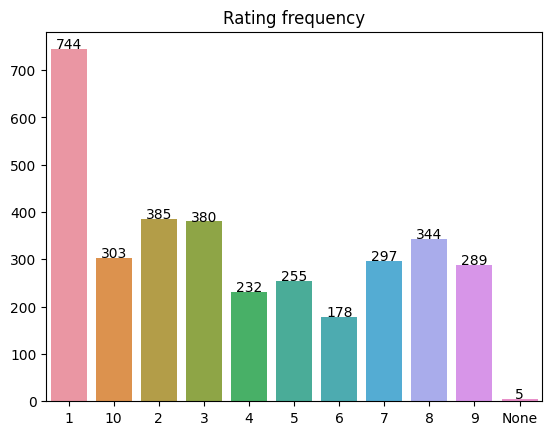

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns_plot = sns.barplot(x=unique_values, y=counts)

# # Add text labels to the bars
for i in range(len(unique_values)):
    sns_plot.text(x=i, y=counts[i]+1, s=counts[i], ha='center')

# Show the plot
plt.title('Rating frequency')
plt.show()

# Preprocessing

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords
nltk.download('stopwords')
english_stopwords = stopwords.words('english')

from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
def remove_unicode(text):
    return text.encode('ascii', 'ignore').decode('utf-8')

def remove_stopword(text):
    text = word_tokenize(text)
    res = [token for token in text if token not in english_stopwords]
    return ' '.join(res)

def stemming(text):
    text = word_tokenize(text)
    res = [stemmer.stem(token) for token in text]
    return ' '.join(res)

def preprocessing_text(text):
  res = text
  res = remove_unicode(res)
  res = remove_stopword(res)
  res = stemming(res)
  return res

In [ ]:
text = 'Is this a played?'

preprocessing_text(text), remove_stopword(text), remove_unicode(text), stemming(text)

('is play ?', 'Is played ?', 'Is this a played?', 'is thi a play ?')

In [ ]:
def new_comment_length(data, option):
  res = []
  length = []
  for sentence in data:
    get = ""
    if(option == 1) :
      get = remove_unicode(sentence)
    elif(option == 2):
      get = remove_stopword(sentence)
    elif(option == 3) :
      get = stemming(sentence)
    else :
      get = preprocessing_text(sentence)
    res.append(get)
    length.append(len(get))
  return res, length

In [ ]:
unicode_comment, unicode_length = new_comment_length(data['Original_comment'], 1)
stopword_comment, stopword_length = new_comment_length(data['Original_comment'], 2)
stemming_comment, stemming_length = new_comment_length(data['Original_comment'], 3)
preprocessing_comment, preprocessing_length = new_comment_length(data['Original_comment'], 4)

In [ ]:
data['Unicode_comment'] = unicode_comment
data['unicode_length'] = unicode_length

data['Stopword_comment'] = stopword_comment
data['stopword_length'] = stopword_length

data['Stemming_comment'] = stemming_comment
data['stemming_length'] = stemming_length

data['Preprocessing_comment'] = preprocessing_comment
data['preprocessing_length'] = preprocessing_length

data = data.drop(['Rates', 'Date', 'Country', 'Verify'], axis = 1)
data

,Stt,Label,Original_comment,original_length,Unicode_comment,unicode_length,Stopword_comment,stopword_length,Stemming_comment,stemming_length,Preprocessing_comment,preprocessing_length
0,0,1,Excellent service both on the ground and on bo...,367,Excellent service both on the ground and on bo...,367,Excellent service ground board - first class p...,267,excel servic both on the ground and on board -...,346,excel servic ground board - first class produc...,244
1,1,1,Good lounge at Cape Town. On time departure. ...,152,Good lounge at Cape Town. On time departure. ...,152,Good lounge Cape Town . On time departure . Dr...,146,good loung at cape town . on time departur . d...,144,good loung cape town . on time departur . drin...,134
2,2,1,A really excellent journey. Lounge not overcr...,703,A really excellent journey. Lounge not overcr...,703,A really excellent journey . Lounge overcrowde...,588,a realli excel journey . loung not overcrowd i...,658,a realli excel journey . loung overcrowd late ...,531
3,3,0,This flight was one of the worst I have ever ...,1191,This flight was one of the worst I have ever ...,1190,This flight one worst I ever life . I wanted p...,808,thi flight wa one of the worst i have ever had...,1114,thi flight one worst i ever life . i want pamp...,715
4,4,0,It seems that there is a race to the bottom am...,575,It seems that there is a race to the bottom am...,575,It seems race bottom amongst airlines . I even...,439,it seem that there is a race to the bottom amo...,544,it seem race bottom amongst airlin . i even ch...,390
...,...,...,...,...,...,...,...,...,...,...,...,...
3407,3413,1,Flew British Airways from Sydney to Venice on ...,358,Flew British Airways from Sydney to Venice on ...,358,Flew British Airways Sydney Venice 22nd April ...,280,flew british airway from sydney to venic on 22...,339,flew british airway sydney venic 22nd april re...,256
3408,3414,1,Recently for our honeymoon we took advantage o...,2353,Recently for our honeymoon we took advantage o...,2353,Recently honeymoon took advantage BA promo fly...,1601,recent for our honeymoon we took advantag of a...,2167,recent honeymoon took advantag ba promo fli si...,1409
3409,3415,0,LGW-Antigua on 29 April and Antigua-LGW on 13 ...,2644,LGW-Antigua on 29 April and Antigua-LGW on 13 ...,2643,LGW-Antigua 29 April Antigua-LGW 13 May Boeing...,1893,lgw-antigua on 29 april and antigua-lgw on 13 ...,2492,lgw-antigua 29 april antigua-lgw 13 may boe 77...,1723
3410,3416,0,LHR-JTR-LHR. A tale of opposites for BA's new ...,615,LHR-JTR-LHR. A tale of opposites for BA's new ...,615,LHR-JTR-LHR . A tale opposites BA 's new route...,487,lhr-jtr-lhr . a tale of opposit for ba 's new ...,577,lhr-jtr-lhr . a tale opposit ba 's new rout sa...,440


In [ ]:
# So sánh về min và max của các câu trước và sau khi tiền xử lý

mi_origin = np.min(data['original_length'].values)
ma_origin = np.max(data['original_length'].values)

mi_unicode = np.min(data['unicode_length'].values)
ma_unicode = np.max(data['unicode_length'].values)

mi_stopword = np.min(data['stopword_length'].values)
ma_stopword = np.max(data['stopword_length'].values)

mi_stemming = np.min(data['stemming_length'].values)
ma_stemming = np.max(data['stemming_length'].values)

mi_preprocessing = np.min(data['preprocessing_length'].values)
ma_preprocessing = np.max(data['preprocessing_length'].values)

In [ ]:
df = pd.DataFrame({'name' : ['origin', 'unicode', 'stopword', 'stemming', 'preprocessing'],
                   'min' : [mi_origin, mi_unicode, mi_stopword, mi_stemming, mi_preprocessing],
                   'max' : [ma_origin, ma_unicode, ma_stopword, ma_stemming, ma_preprocessing]
                   })
df

,name,min,max
0,origin,83,3529
1,unicode,83,3529
2,stopword,66,2680
3,stemming,80,3347
4,preprocessing,59,2427


# Hugging Face transformer
# Model : cardiffnlp/twitter-roberta-base-sentiment-latest

In [ ]:
!pip install -q transformers
from transformers import pipeline
senti_pipeline = pipeline("sentiment-analysis", model = 'cardiffnlp/twitter-roberta-base-sentiment-latest')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 69.3 MB/s eta 0:00:00


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.


In [ ]:
def labelling(df):
  new_label = []
  score = []
  for row in df:
    get = senti_pipeline(row, truncation=True, max_length=512)[0]
    label = 3
    if(get['label'] == 'positive'):
      label = 1
    elif(get['label'] == 'negative'):
      label = 0
    else:
      label = 2
    new_label.append(label)
    score.append(get['score'])
  new_label = pd.Series(new_label)
  score = pd.Series(score)
  return new_label, score

## Phân tích và lấy ra các nhãn sau khi đã chạy mô hình transformer, mất nhiều thời gian cho bước này

Code này để mô hình gán nhãn

In [ ]:
# Original_label, Original_score = labelling(data['Original_comment'])
# Unicode_label, Unicode_score = labelling(data['Unicode_comment'])
# Stopword_label, Stopword_score = labelling(data['Stopword_comment'])
# Stemming_label, Stemming_score = labelling(data['Stemming_comment'])
# Preprocessing_label, Preprocessing_score = labelling(data['Preprocessing_comment'])

## Dữ liệu đã được mô hình đã được nhóm lưu lại, import dữ liệu được lưu sẵn để tiết kiệm thời gian

In [ ]:
data_hf_original = pd.read_csv("label_original.csv")
data_hf_unicode = pd.read_csv("label_unicode.csv")
data_hf_stopword = pd.read_csv("label_stopword.csv")
data_hf_stemming = pd.read_csv("label_stemming.csv")
data_hf_preprocessing = pd.read_csv("label_preprocessing.csv")

Đưa các nhãn được máy gán vào dataframe gốc

In [ ]:
data['Label_original'] = data_hf_original['Original_label']
data['Label_unicode'] = data_hf_unicode['Unicode_label']
data['Label_stemming'] = data_hf_stemming['Stemming_label']
data['Label_stopword'] = data_hf_stopword['Stopword_label']
data['Label_preprocessing'] = data_hf_preprocessing['Preprocessing_label']

## Dựa vào việc đánh trọng số của nhãn (data người gán: 0.4, mỗi df máy gán: 0.12) để cho ra bộ dữ liệu cuối cùng

In [ ]:
list_columns = ['Label', 'Label_original', 'Label_unicode', 'Label_stemming', 'Label_stopword', 'Label_preprocessing']
final_label = []

for i in range(0,len(data)):
  total_0 = 0
  total_1 = 0
  total_2 = 0
  for j in list_columns:
    if (data[j][i] == 0):
      if(j == 'Label'):
        total_0 += 0.4
      else:
        total_0 += 0.12
    if (data[j][i] == 1):
      if(j == 'Label'):
        total_1 += 0.4
      else:
        total_1 += 0.12
    if (data[j][i] == 2):
      if(j == 'Label'):
        total_2 += 0.4
      else:
        total_2 += 0.12

  final = np.argmax([total_0,total_1,total_2])
  final_label.append(final)
  total_0 = 0
  total_1 = 0
  total_2 = 0

data['Final_label'] = final_label

In [ ]:
f1_score(data['Final_label'], data['Label'], average='macro')

0.8846984888498084

# Basic Models

## Support Vector Classifier (SVC)

In [ ]:
def model_SVC(X, y):

  #Chia tập train và test
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

  # Áp dụng mô hình TfidfVectorizer để chuyển văn bản thành các vector đặc trưng
  tfidf = TfidfVectorizer()
  X_train_tfidf = tfidf.fit_transform(X_train)
  X_test_tfidf = tfidf.transform(X_test)

  # Tạo model SVC default
  svm_model = SVC()

  # Train mô hình với dữ liệu là vector đặc trưng từ văn bản và nhãn
  svm_model.fit(X_train_tfidf, y_train)

  # Dự đoán nhãn từ mô hình SVC
  y_pred_svm = svm_model.predict(X_test_tfidf)

  # Tính accuracy và độ đo F1 score (macro)
  accuracy_svm = accuracy_score(y_test, y_pred_svm)
  f1_macro_svm = f1_score(y_test, y_pred_svm, average='macro')
  f1_weighted_svm = f1_score(y_test, y_pred_svm, average='weighted')
  print("Accuracy:", accuracy_svm)
  print("F1 macro: ", f1_macro_svm)
  print("F1 weighted: ", f1_weighted_svm)

  # Ploting
  cm = confusion_matrix(y_test, y_pred_svm)
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', ax=ax)
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')

Kết quả

Accuracy: 0.7397420867526378
F1 macro:  0.5927927617729205
F1 weighted:  0.6908667966227496


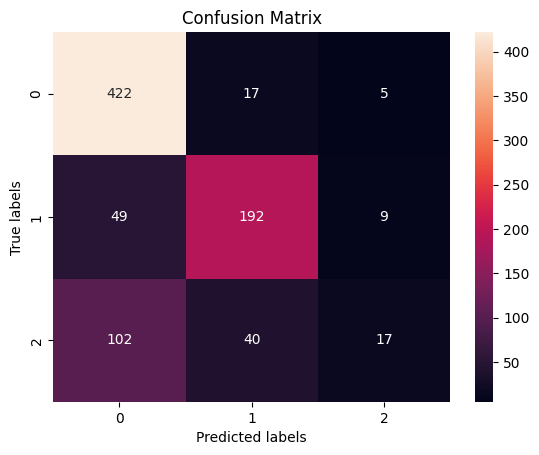

In [ ]:
X = data['Original_comment']
y = data['Final_label']
model_SVC(X, y)

## XGBoost Classifier (XGBC)

In [ ]:
def model_XGBC(X, y):

  #Chia tập train và test
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

  # Áp dụng mô hình TfidfVectorizer để chuyển văn bản thành các vector đặc trưng
  tfidf = TfidfVectorizer()
  X_train_tfidf = tfidf.fit_transform(X_train)
  X_test_tfidf = tfidf.transform(X_test)

  # Tạo model XGBC default
  xgbc_model = XGBClassifier()

  # Train mô hình với dữ liệu là vector đặc trưng từ văn bản và nhãn
  xgbc_model.fit(X_train_tfidf, y_train)

  # Dự đoán nhãn từ mô hình XGBC
  y_pred_xgbc = xgbc_model.predict(X_test_tfidf)

  # Tính accuracy và độ đo F1 score (macro)
  accuracy_xgbc = accuracy_score(y_test, y_pred_xgbc)
  f1_macro_xgbc = f1_score(y_test, y_pred_xgbc, average='macro')
  f1_weighted_xgbc = f1_score(y_test, y_pred_xgbc, average='weighted')
  print("Accuracy: ", accuracy_xgbc)
  print("F1 macro: ", f1_macro_xgbc)
  print("F1 weighted: ", f1_weighted_xgbc)

  #Ploting
  cm = confusion_matrix(y_test, y_pred_xgbc)
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', ax=ax)
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')

Kết quả

Accuracy:  0.7198124267291911
F1 macro:  0.6024977846850504
F1 weighted:  0.6893714102175335


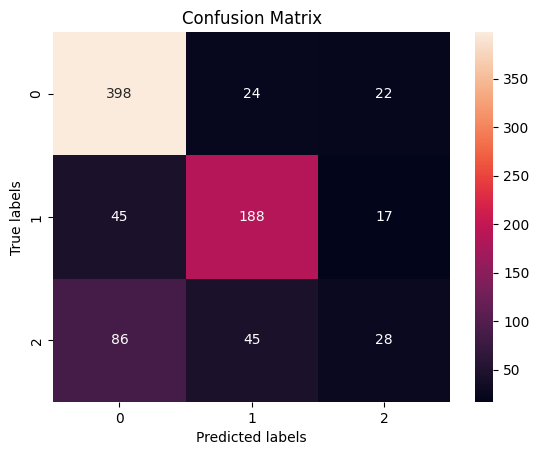

In [ ]:
X = data['Original_comment']
y = data['Final_label']
model_XGBC(X, y)

# Experiments

## Balancing the data distribution

In [ ]:
import random

data_0 = data[data['Final_label'] ==0]
data_temp = data[data['Final_label'] !=0]

list_num = list(range(0,len(data_0)))
list_num_final = []
for i in range(0,1000):
  random.shuffle(list_num)
  list_num_final.append(list_num[0])
  list_num = list_num[1:]

data_new = data_0.iloc[list_num_final].append(data_temp)
data_new['Final_label'].value_counts()

Accuracy: 0.688622754491018
F1 macro:  0.6043100783409732
F1 weighted:  0.6392874091249419


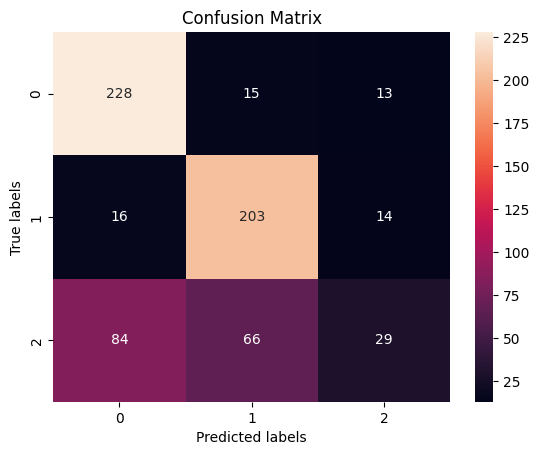

In [ ]:
X = data_new['Original_comment']
y = data_new['Final_label']
model_SVC(X, y)

Accuracy:  0.6646706586826348
F1 macro:  0.6145883200664226
F1 weighted:  0.6417007770520169


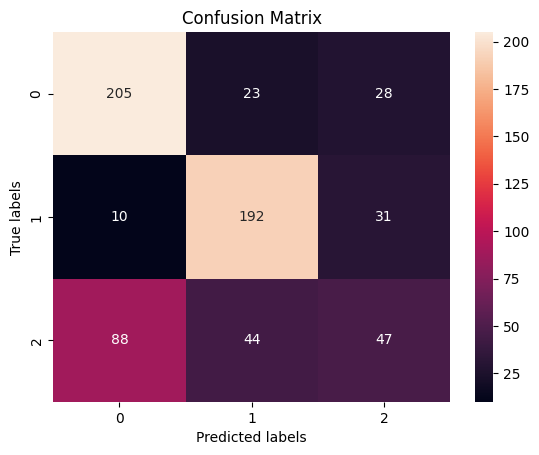

In [ ]:
X = data_new['Original_comment']
y = data_new['Final_label']
model_XGBC(X, y)

## GridSearchCV

### Mô hình tìm tham số từ GridSearchCV

Vì trong quá trình tìm tham số sẽ chạy khá lâu nên nhóm để code như sau, và xin lấy các tham số tối ưu nhất đã chạy từ trước đó để áp dụng vào các mô hình

In [ ]:
def find_Hyperparameters(X, y):

  # Tham số chạy thử cho Decision Tree
  params_dt = {
      # 'model__criterion': ['gini', 'entropy', 'log_loss'], fail - gini best
      'model__max_depth': [4, 5, 6, 7],
      'model__min_samples_split': [2, 3, 4],
      'model__min_samples_leaf': [1, 2, 3],
      # 'model__max_features': ['sqrt', 'log2', None], fail - None best
  }

  # Tham số chạy thử cho SVC
  params_svc = {
              'model__C': [0.1, 1, 10],
              'model__gamma': ['scale', 'auto'],
              'model__kernel': ['linear', 'sigmoid', 'rbf']
  }

  # Tham số chạy thử cho Gradient Boosting
  params_gb = {
      # default: losss->log_loss
      # 'model__loss': ['log_loss', 'exponential'], fail, log_loss best
      'model__learning_rate': [0.05, 0.1, 0.15, 0.2],
      'model__criterion': ['friedman_mse', 'squared_error'],
      'model__n_estimators': [50, 100, 150],
  }

  # Tham số chạy thử cho XGBoost
  params_xgb = {
    'model__learning_rate': [0.05, 0.1, 0.15, 0.2],
    'model__n_estimators': [50, 100, 150],
    'model__objective': ['reg:squarederror', 'binary:logistic', 'multi:softprob'],
  }

  params_nn = {
    'model__hidden_layer_sizes': [(100,), (50, 50), (100, 50, 25)],
    'model__activation': ['relu', 'tanh'],
    'model__alpha': [0.0001, 0.001, 0.01],
    'model__learning_rate': ['constant', 'adaptive']
  }

  # Áp dụng mô hình TfidfVectorizer để chuyển văn bản thành các vector đặc trưng
  tknzr = TweetTokenizer()
  vectorizer = TfidfVectorizer()

  # Import các mô hình
  dt_model = DecisionTreeClassifier(random_state=42)
  svc_model = SVC()
  xgb_model = XGBClassifier()

  # Gán params và model cần chạy để tìm tham số tối ưu
  params_this_time = params_nn
  model_this_time = nn_model

  # Tạo pipeline
  pipeline = Pipeline([
      ('vectorizer', vectorizer),
      ('model', model_this_time)
  ])

  # GridSearch tìm tham số tối ưu
  grid_search = GridSearchCV(pipeline, params_this_time, refit = True, verbose = 3)
  grid_search.fit(X, y)
  return grid_search

In [ ]:
X = data['Original_comment']
y = data['Final_label']
gridSearch = find_Hyperparameters(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[CV 3/5] END model__activation=relu, model__alpha=0.0001, model__hidden_layer_sizes=(100,), model__learning_rate=adaptive;, score=0.669 total time=   2.1s


In [ ]:
gridSearch.best_params_

{'model__learning_rate': 0.2,
 'model__n_estimators': 150,
 'model__objective': 'reg:squarederror'}

### Các mô hình và kết quả đạt được từ tham số tối ưu tìm được

*   Với Decision Tree: max_depth= 6, min_samples_leaf= 2, min_samples_split= 2
*   Với SVC: C=10, gamma = 'scale', kernel = 'rbf'
*   Với XGBoost: learning_rate=0.2, n_estimators= 150, objective = 'multi:squarederror', num_class = 3

#### SVC

Mô hình

In [ ]:
def model_SVC(X, y):

  #Chia tập train và test
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

  # Tạo mô hình TweetTokenizer
  tknzr = TweetTokenizer()

  # Áp dụng mô hình TfidfVectorizer để chuyển văn bản thành các vector đặc trưng và có sự hỗ trợ tách các token từ TweetTokenizer
  tfidf = TfidfVectorizer()
  X_train_tfidf = tfidf.fit_transform(X_train)
  X_test_tfidf = tfidf.transform(X_test)

  # Tạo model SVC với các tham số tối ưu đã được chạy từ GridSearchCV
  svm_model = SVC(C=10, gamma = 'scale', kernel = 'rbf')

  # Train mô hình với dữ liệu là vector đặc trưng từ văn bản và nhãn
  svm_model.fit(X_train_tfidf, y_train)

  # Dự đoán nhãn từ mô hình SVC
  y_pred_svm = svm_model.predict(X_test_tfidf)

  # Tính accuracy và độ đo F1 score (macro)
  accuracy_svm = accuracy_score(y_test, y_pred_svm)
  f1_macro_svm = f1_score(y_test, y_pred_svm, average='macro')
  f1_weighted_svm = f1_score(y_test, y_pred_svm, average='weighted')
  print("Accuracy:", accuracy_svm)
  print("F1 macro: ", f1_macro_svm)
  print("F1 weighted: ", f1_weighted_svm)

  # Ploting
  cm = confusion_matrix(y_test, y_pred_svm)
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', ax=ax)
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')

Kết quả

Accuracy: 0.7409144196951934
F1 macro:  0.624684083206571
F1 weighted:  0.7095006284809846


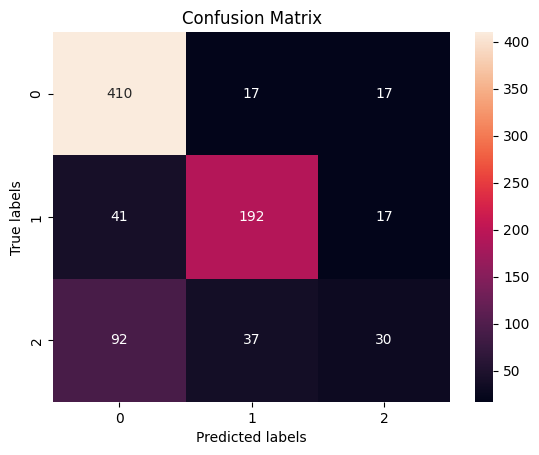

In [ ]:
X = data['Original_comment']
y = data['Final_label']
model_SVC(X, y)

#### XGBC

Mô hình

In [ ]:
def model_XGBC(X, y):

  #Chia tập train và test
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

  # Tạo mô hình TweetTokenizer
  tknzr = TweetTokenizer()

  # Áp dụng mô hình TfidfVectorizer để chuyển văn bản thành các vector đặc trưng và có sự hỗ trợ tách các token từ TweetTokenizer
  tfidf = TfidfVectorizer()
  X_train_tfidf = tfidf.fit_transform(X_train)
  X_test_tfidf = tfidf.transform(X_test)

  # Tạo model XGBC với các tham số tối ưu đã được chạy từ GridSearchCV
  xgbc_model = XGBClassifier(learning_rate=0.2, n_estimators= 150, objective = 'multi:squarederror', num_class = 3)

  # Train mô hình với dữ liệu là vector đặc trưng từ văn bản và nhãn
  xgbc_model.fit(X_train_tfidf, y_train)

  # Dự đoán nhãn từ mô hình XGBC
  y_pred_xgbc = xgbc_model.predict(X_test_tfidf)

  # Tính accuracy và độ đo F1 score (macro)
  accuracy_xgbc = accuracy_score(y_test, y_pred_xgbc)
  f1_macro_xgbc = f1_score(y_test, y_pred_xgbc, average='macro')
  f1_weighted_xgbc = f1_score(y_test, y_pred_xgbc, average='weighted')
  print("Accuracy: ", accuracy_xgbc)
  print("F1 macro: ", f1_macro_xgbc)
  print("F1 weighted: ", f1_weighted_xgbc)

  #Ploting
  cm = confusion_matrix(y_test, y_pred_xgbc)
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', ax=ax)
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')

Kết quả

Accuracy:  0.7280187573270809
F1 macro:  0.6124047038764086
F1 weighted:  0.698276931109602


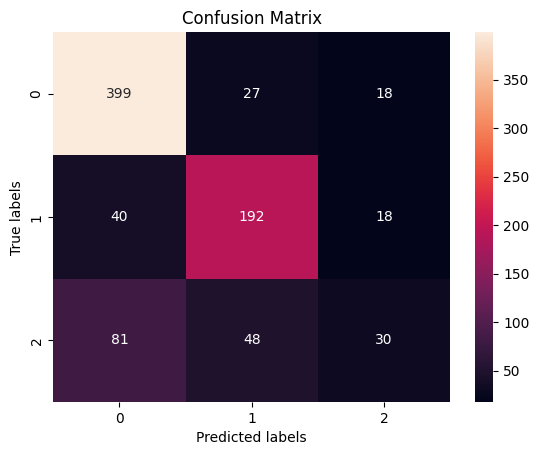

In [ ]:
X = data['Original_comment']
y = data['Final_label']
model_XGBC(X, y)

# Analyze the results

Mô hình SVC là mô hình đưa ra hiệu suất tốt nhất, test mô hình SVC:

In [ ]:
def model_SVC(X, y):

  # Tạo mô hình TweetTokenizer
  tknzr = TweetTokenizer()

  # Áp dụng mô hình TfidfVectorizer để chuyển văn bản thành các vector đặc trưng và có sự hỗ trợ tách các token từ TweetTokenizer
  tfidf = TfidfVectorizer(tokenizer=tknzr.tokenize, token_pattern=None)
  X_tfidf = tfidf.fit_transform(X)

  # Tạo model SVC với các tham số tối ưu đã được chạy từ GridSearchCV
  svm_model = SVC(C=10, gamma = 'scale', kernel = 'rbf')

  # Train mô hình với dữ liệu là vector đặc trưng từ văn bản và nhãn
  svm_model.fit(X_tfidf, y)

  # Trả về mô hình Tfidf và SVM để phục vụ dự đoán
  return tfidf, svm_model

Train lại mô hình

In [ ]:
X = data['Original_comment']
y = data['Final_label']
tfidf, model = model_SVC(X, y)

Dự đoán các đoạn text cho sẵn

In [ ]:
# Đưa ra đoạn text cần dự đoán
texts = ["The service from BA is really good, love it!", \
        "Worst experience I ever had, trying to avoid BA next time",]
# Chuyển đoạn text thành vector đặc trưng từ TfidfVectorizer đã được train sẵn
texts_tfidf = tfidf.transform(texts)

# Dùng model để dự đoán nhãn cho đoạn text
predictions = model.predict(texts_tfidf)

# In ra kết quả dự đoán
print(predictions)

[1 0]
